In [1]:
# ---------------------------------------------------------
# Cholesterol Meal Plan Evaluation Notebook
# Author: Kshitiz Sikriwal
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

pd.set_option("display.float_format", lambda x: f"{x:.2f}")
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["axes.grid"] = True

DATA_PATH = Path("/Users/kshitizsikriwal/Kshitiz/evaluation/Gemini/meal_to_yoga_top1_contrastive_Cholesterol (1).xlsx")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"❌ File not found: {DATA_PATH.resolve()}")

df = pd.read_excel(DATA_PATH, sheet_name=None)
sheet_name = list(df.keys())[0]
df = df[sheet_name]

print(f"✅ Loaded: {DATA_PATH.name} | Sheet: {sheet_name} | Shape: {df.shape}")
display(df.head(3))


✅ Loaded: meal_to_yoga_top1_contrastive_Cholesterol (1).xlsx | Sheet: Sheet1 | Shape: (42, 29)


,meal_index,meal_plan,meal_day,meal_time,meal_name,meal_description,Calories (kcal),Zinc (mg),Copper (mg),Iron (mg),...,Selenium (µg),Magnesium (mg),yoga_index,yoga_plan,yoga_day,yoga_time,yoga_detailed,yoga_exercise,yoga_precautions,similarity
0,0,Plan A,Monday,Morning,Oatmeal with Walnuts,"Steel-cut oats with walnuts, flaxseed, and ban...",500.00,2.50,0.40,2.50,...,15,110,105,Plan B,Monday,Morning,"Surya Namaskar (Sun Salutation), 6 rounds at a...",30 minutes of moderate-intensity interval trai...,HIIT is superior for improving lipid profiles ...,0.21
1,1,Plan A,Monday,Afternoon,Spinach & Chicken Salad,"Large spinach salad with grilled chicken, chic...",700.00,3.00,0.30,5.50,...,20,120,106,Plan B,Monday,Afternoon,Trikonasana (Triangle Pose) and Parsvakonasana...,20 minutes of brisk walking (5.5 km/h) to main...,Focus on hydration with water. Avoid high-suga...,0.26
2,2,Plan A,Monday,Evening,Baked Salmon & Sweet Potato,Baked salmon with steamed broccoli and a mediu...,800.00,3.50,0.40,4.00,...,25,100,107,Plan B,Monday,Evening,"Setu Bandhasana (Bridge Pose), 3 dynamic reps ...",No exercise prescribed. This session actively ...,Emphasize relaxation and cultivate awareness o...,0.22


In [2]:
# ---------------------------------------------------------
# Normalize column names & detect plan/day columns
# ---------------------------------------------------------
def canon(txt):
    if pd.isna(txt): return txt
    return "_".join(str(txt).strip().lower().split())

df.columns = [canon(c) for c in df.columns]

plan_col = next((c for c in df.columns if "plan" in c), None)
day_col  = next((c for c in df.columns if "day" in c), None)
if not plan_col or not day_col:
    raise ValueError(f"❌ Could not auto-detect plan/day columns. Columns: {list(df.columns)}")

df[plan_col] = df[plan_col].astype(str).apply(canon)
df[day_col]  = df[day_col].astype(str).apply(canon)

print(f"🧩 Plan column: {plan_col} | Day column: {day_col}")
print("Detected plans:", df[plan_col].unique())
print("Detected days:", df[day_col].unique())


🧩 Plan column: meal_plan | Day column: meal_day
Detected plans: ['plan_a' 'plan_b']
Detected days: ['monday' 'tuesday' 'wednesday' 'thursday' 'friday' 'saturday' 'sunday']


In [3]:
# ---------------------------------------------------------
# Robust nutrient mapping (15 nutrients)
# ---------------------------------------------------------
nutrient_patterns = {
    "Calories (kcal)"            : ["calorie","energy","kcal"],
    "Zinc (mg)"                  : ["zinc"],
    "Copper (mg)"                : ["copper"],
    "Iron (mg)"                  : ["iron"],
    "Chromium (µg)"              : ["chromium"],
    "Potassium (mg)"             : ["potassium","k"],
    "Phosphorus (mg)"            : ["phosphorus","phosphate"],
    "Vitamin B1 (Thiamin) (mg)"  : ["thiamin","vitamin_b1","b1"],
    "Vitamin B2 (Riboflavin) (mg)": ["riboflavin","vitamin_b2","b2"],
    "Vitamin B3 (Niacin) (mg)"   : ["niacin","vitamin_b3","b3"],
    "Vitamin B6 (mg)"            : ["vitamin_b6","b6"],
    "Vitamin B9 (Folate) (µg)"   : ["folate","folic","vitamin_b9","b9"],
    "Vitamin B12 (µg)"           : ["vitamin_b12","b12"],
    "Selenium (µg)"              : ["selenium","se"],
    "Magnesium (mg)"             : ["magnesium","mg"]
}

matched = {}
for friendly, pats in nutrient_patterns.items():
    for p in pats:
        hit = next((col for col in df.columns if p in col), None)
        if hit:
            matched[friendly] = hit
            break

print("🧮 Nutrient Mapping:")
for k,v in matched.items():
    print(f"  {k:35s} → {v}")

found_cols = list(matched.values())
if not found_cols:
    raise ValueError("❌ No nutrient columns found!")

for c in found_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")


🧮 Nutrient Mapping:
  Calories (kcal)                     → calories_(kcal)
  Zinc (mg)                           → zinc_(mg)
  Copper (mg)                         → copper_(mg)
  Iron (mg)                           → iron_(mg)
  Chromium (µg)                       → chromium_(µg)
  Potassium (mg)                      → potassium_(mg)
  Phosphorus (mg)                     → phosphorus_(mg)
  Vitamin B1 (Thiamin) (mg)           → vitamin_b1_(thiamin,_mg)
  Vitamin B2 (Riboflavin) (mg)        → vitamin_b2_(riboflavin,_mg)
  Vitamin B3 (Niacin) (mg)            → vitamin_b3_(niacin,_mg)
  Vitamin B6 (mg)                     → vitamin_b6_(mg)
  Vitamin B9 (Folate) (µg)            → vitamin_b9_(folate,_µg)
  Vitamin B12 (µg)                    → vitamin_b12_(µg)
  Selenium (µg)                       → selenium_(µg)
  Magnesium (mg)                      → magnesium_(mg)


In [4]:
# ---------------------------------------------------------
# Aggregate daily totals → compute weekly averages
# ---------------------------------------------------------
daily_totals = (
    df.groupby([plan_col, day_col], as_index=False)[found_cols]
      .sum().sort_values([plan_col, day_col])
)
weekly_avg = daily_totals.groupby(plan_col)[found_cols].mean()

dataset_to_friendly = {v:k for k,v in matched.items()}

def make_series(plan_name):
    if plan_name not in weekly_avg.index:
        return pd.Series(dtype=float)
    return weekly_avg.loc[plan_name].rename(index=dataset_to_friendly)

weekly_avg_main = make_series("plan_a")
weekly_avg_alt  = make_series("plan_b")

print("✅ Weekly Averages Computed")
display(weekly_avg_main.round(2))
display(weekly_avg_alt.round(2))


✅ Weekly Averages Computed


Calories (kcal)                1885.71
Zinc (mg)                       123.07
Copper (mg)                       1.63
Iron (mg)                        11.84
Chromium (µg)                    25.86
Potassium (mg)                 3401.43
Phosphorus (mg)                1357.14
Vitamin B1 (Thiamin) (mg)        72.59
Vitamin B2 (Riboflavin) (mg)      1.20
Vitamin B3 (Niacin) (mg)         26.50
Vitamin B6 (mg)                   4.27
Vitamin B9 (Folate) (µg)        334.29
Vitamin B12 (µg)                  3.11
Selenium (µg)                    61.43
Magnesium (mg)                  335.71
Name: plan_a, dtype: float64

Calories (kcal)                1935.71
Zinc (mg)                        80.43
Copper (mg)                       1.47
Iron (mg)                        12.76
Chromium (µg)                    26.50
Potassium (mg)                 3508.29
Phosphorus (mg)                1307.14
Vitamin B1 (Thiamin) (mg)        51.17
Vitamin B2 (Riboflavin) (mg)      1.16
Vitamin B3 (Niacin) (mg)         25.09
Vitamin B6 (mg)                   2.31
Vitamin B9 (Folate) (µg)        321.50
Vitamin B12 (µg)                 20.59
Selenium (µg)                    71.43
Magnesium (mg)                  338.57
Name: plan_b, dtype: float64

In [5]:
# ---------------------------------------------------------
# Real-world nutritional midpoints (Cholesterol management)
# ---------------------------------------------------------
guideline_mid = pd.Series({
    "Calories (kcal)"             : (1800 + 2200) / 2,   # 2000
    "Zinc (mg)"                   : (8 + 11) / 2,        # 9.5
    "Copper (mg)"                 : (0.9 + 1.3) / 2,     # 1.1
    "Iron (mg)"                   : (8 + 18) / 2,        # 13
    "Chromium (µg)"               : (25 + 35) / 2,       # 30
    "Potassium (mg)"              : (3400 + 4700) / 2,   # 4050
    "Phosphorus (mg)"             : (700 + 1250) / 2,    # 975
    "Vitamin B1 (Thiamin) (mg)"   : (1.1 + 1.2) / 2,     # 1.15
    "Vitamin B2 (Riboflavin) (mg)": (1.1 + 1.3) / 2,     # 1.2
    "Vitamin B3 (Niacin) (mg)"    : (14 + 35) / 2,       # 24.5
    "Vitamin B6 (mg)"             : (1.3 + 2.0) / 2,     # 1.65
    "Vitamin B9 (Folate) (µg)"    : (300 + 400) / 2,     # 350
    "Vitamin B12 (µg)"            : (2.4 + 4.0) / 2,     # 3.2
    "Selenium (µg)"               : (55 + 70) / 2,       # 62.5
    "Magnesium (mg)"              : (310 + 420) / 2      # 365
})

guideline_mid = guideline_mid.reindex(weekly_avg_main.index)
print("📘 Cholesterol Guideline Midpoints (WHO / NIH / DRI)")
display(guideline_mid.round(2))


📘 Cholesterol Guideline Midpoints (WHO / NIH / DRI)


Calories (kcal)                2000.00
Zinc (mg)                         9.50
Copper (mg)                       1.10
Iron (mg)                        13.00
Chromium (µg)                    30.00
Potassium (mg)                 4050.00
Phosphorus (mg)                 975.00
Vitamin B1 (Thiamin) (mg)         1.15
Vitamin B2 (Riboflavin) (mg)      1.20
Vitamin B3 (Niacin) (mg)         24.50
Vitamin B6 (mg)                   1.65
Vitamin B9 (Folate) (µg)        350.00
Vitamin B12 (µg)                  3.20
Selenium (µg)                    62.50
Magnesium (mg)                  365.00
dtype: float64

In [6]:
# ---------------------------------------------------------
# Compute MAE, MSE, RMSE per plan
# ---------------------------------------------------------
def compute_errors(pred, real):
    df_err = pd.DataFrame({"Predicted": pred, "Guideline": real})
    df_err["Absolute Error"] = (df_err["Predicted"] - df_err["Guideline"]).abs()
    df_err["Percentage Error (%)"] = (df_err["Absolute Error"] / df_err["Guideline"]) * 100
    mae = df_err["Absolute Error"].mean()
    mse = (df_err["Absolute Error"] ** 2).mean()
    rmse = np.sqrt(mse)
    metrics = pd.Series({"MAE": mae, "MSE": mse, "RMSE": rmse}).round(3)
    return df_err.round(2), metrics

main_errors, main_metrics = compute_errors(weekly_avg_main, guideline_mid)
alt_errors,  alt_metrics  = compute_errors(weekly_avg_alt,  guideline_mid)

print("📈 Cholesterol — Plan A (Main) Errors")
display(main_errors)
display(main_metrics)

print("\n📈 Cholesterol — Plan B (Alternate) Errors")
display(alt_errors)
display(alt_metrics)


📈 Cholesterol — Plan A (Main) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1885.71,2000.00,114.29,5.71
Zinc (mg),123.07,9.50,113.57,1195.49
Copper (mg),1.63,1.10,0.53,48.05
Iron (mg),11.84,13.00,1.16,8.90
Chromium (µg),25.86,30.00,4.14,13.81
Potassium (mg),3401.43,4050.00,648.57,16.01
Phosphorus (mg),1357.14,975.00,382.14,39.19
Vitamin B1 (Thiamin) (mg),72.59,1.15,71.44,6211.80
Vitamin B2 (Riboflavin) (mg),1.20,1.20,0.00,0.00
Vitamin B3 (Niacin) (mg),26.50,24.50,2.00,8.16


MAE       92.44
MSE    39925.08
RMSE     199.81
dtype: float64


📈 Cholesterol — Plan B (Alternate) Errors


,Predicted,Guideline,Absolute Error,Percentage Error (%)
Calories (kcal),1935.71,2000.00,64.29,3.21
Zinc (mg),80.43,9.50,70.93,746.62
Copper (mg),1.47,1.10,0.37,33.77
Iron (mg),12.76,13.00,0.24,1.87
Chromium (µg),26.50,30.00,3.50,11.67
Potassium (mg),3508.29,4050.00,541.71,13.38
Phosphorus (mg),1307.14,975.00,332.14,34.07
Vitamin B1 (Thiamin) (mg),51.17,1.15,50.02,4349.69
Vitamin B2 (Riboflavin) (mg),1.16,1.20,0.04,3.57
Vitamin B3 (Niacin) (mg),25.09,24.50,0.59,2.39


MAE       76.38
MSE    27822.99
RMSE     166.80
dtype: float64

,Guideline (Midpoint),Predicted (Plan A),Predicted (Plan B),Z-Score (Plan A),Z-Score (Plan B)
Calories (kcal),2000.00,1885.71,1935.71,-0.11,-0.06
Zinc (mg),9.50,123.07,80.43,0.10,0.07
Copper (mg),1.10,1.63,1.47,0.00,0.00
Iron (mg),13.00,11.84,12.76,-0.00,-0.00
Chromium (µg),30.00,25.86,26.50,-0.00,-0.00
Potassium (mg),4050.00,3401.43,3508.29,-0.60,-0.50
Phosphorus (mg),975.00,1357.14,1307.14,0.35,0.31
Vitamin B1 (Thiamin) (mg),1.15,72.59,51.17,0.07,0.05
Vitamin B2 (Riboflavin) (mg),1.20,1.20,1.16,-0.00,-0.00
Vitamin B3 (Niacin) (mg),24.50,26.50,25.09,0.00,0.00


🔹 Avg |Z| (Plan A) = 0.086
🔹 Avg |Z| (Plan B) = 0.071


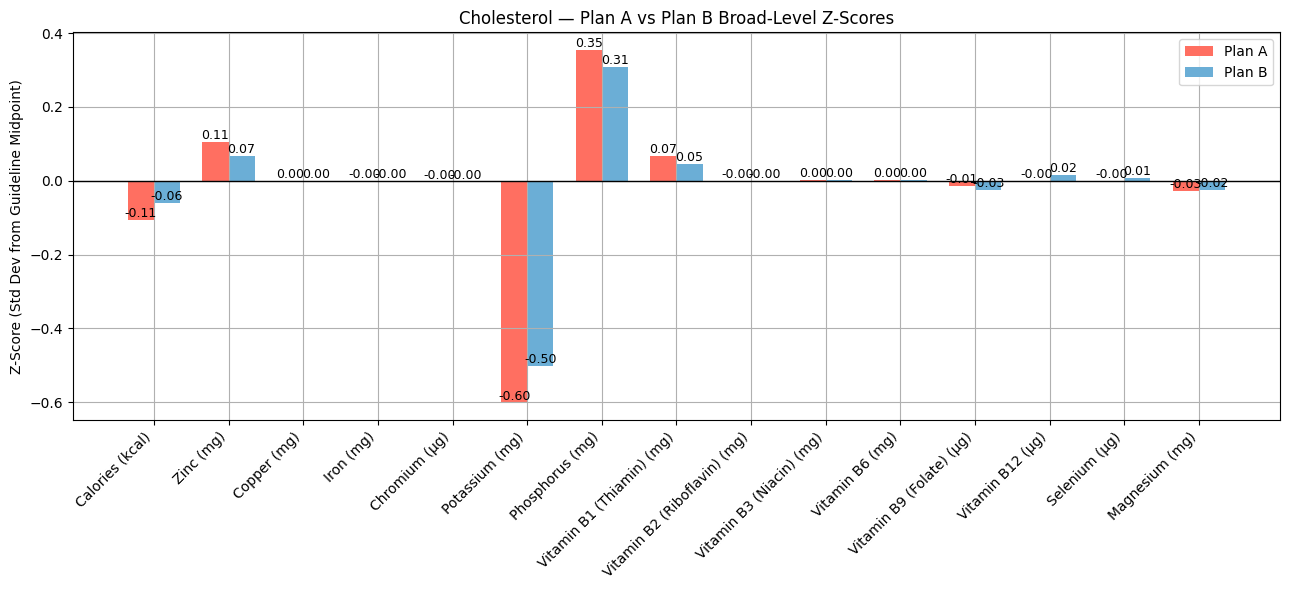

In [7]:
# ---------------------------------------------------------
# Broad-level Z-Score calculation (Plan A & Plan B)
# ---------------------------------------------------------
guideline_std = np.std(guideline_mid.values, ddof=0)

z_main = (weekly_avg_main.values - guideline_mid.values) / guideline_std
z_alt  = (weekly_avg_alt.values  - guideline_mid.values) / guideline_std

z_main_series = pd.Series(z_main, index=guideline_mid.index, name="Z-Score (Plan A)")
z_alt_series  = pd.Series(z_alt,  index=guideline_mid.index, name="Z-Score (Plan B)")

z_df = pd.DataFrame({
    "Guideline (Midpoint)" : guideline_mid,
    "Predicted (Plan A)"   : weekly_avg_main,
    "Predicted (Plan B)"   : weekly_avg_alt,
    "Z-Score (Plan A)"     : z_main_series,
    "Z-Score (Plan B)"     : z_alt_series
}).round(3)

display(z_df)

avg_abs_z_main = np.abs(z_main_series).mean()
avg_abs_z_alt  = np.abs(z_alt_series).mean()
print(f"🔹 Avg |Z| (Plan A) = {avg_abs_z_main:.3f}")
print(f"🔹 Avg |Z| (Plan B) = {avg_abs_z_alt:.3f}")

# Annotated bar chart
x = np.arange(len(z_df.index))
bar_width = 0.35
fig, ax = plt.subplots(figsize=(13,6))
bars1 = ax.bar(x - bar_width/2, z_main_series, width=bar_width, label="Plan A", color="#FF6F61")
bars2 = ax.bar(x + bar_width/2, z_alt_series,  width=bar_width, label="Plan B", color="#6BAED6")

for bars in [bars1, bars2]:
    for b in bars:
        h = b.get_height()
        ax.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom', fontsize=9)

ax.axhline(0, color='black', linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(z_df.index, rotation=45, ha='right')
ax.set_ylabel("Z-Score (Std Dev from Guideline Midpoint)")
ax.set_title("Cholesterol — Plan A vs Plan B Broad-Level Z-Scores")
ax.legend()
plt.tight_layout()
plt.show()
